# ML Pipeline

V3 : simple pipeline with few features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pickle
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rxr
from region_new import Region
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *

from ml.add_all_features import *
from ml.preprocessing import *
from ml.model import *

In [3]:
# Concatenates GeoTiff tiles for a given (city, variable)
from region_new.utils import rasters_to_mosaic 
from rasterio.merge import merge

In [4]:
rasters_to_mosaic('wsf', 'Cairo')

In [5]:
rasters_to_mosaic('wsf', 'Johannesburg')

### ML Pipeline on Turkish Cities

##### Prepare the four cities `(skip if pickled)`

In [6]:
ordu_path = os.path.join("data", "ml", "datasets", "Ordu.pkl")
manisa_path = os.path.join("data", "ml", "datasets","Manisa.pkl")
adana_path = os.path.join("data", "ml", "datasets","Adana.pkl")
trabzon_path = os.path.join("data", "ml", "datasets","Trabzon.pkl")

In [7]:
with open(ordu_path, 'rb') as f:     
    ordu = pickle.load(f)
    f.close()
with open(adana_path, 'rb') as f:     
    adana = pickle.load(f)
    f.close()
with open(manisa_path, 'rb') as f:     
    manisa = pickle.load(f)
    f.close()
with open(trabzon_path, 'rb') as f:     
    trabzon = pickle.load(f)
    f.close()

In [ ]:
data = merge_cities([ordu, manisa, adana, trabzon])
data.isna().sum()

In [ ]:
data = format_type(data)

In [11]:
# Data Preparation for the whole country is quite long.
# So better save the result to spare some computation time
turkey_path = os.path.join("data", "ml", "datasets", "Turkey.pkl")
with open(turkey_path,"wb") as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
turkey_path = os.path.join("data", "ml", "datasets", "Turkey.pkl")
with open(turkey_path,"rb") as f:
    data = pickle.load(f)

##### Preprocessor

In [5]:
data = clean_columns(data)
train, pred = split(data, 'residential')
X, y = training_split(train, 'residential')
print(X.shape, y.shape)
preprocessor = preprocesor()

(29771, 9) (29771,)


##### Training

(17862, 9) (17862,)
KNeighborsClassifier()
f1 score :  0.9809310653536257
Score :  0.9623780318294889
RandomForestClassifier()
f1 score :  0.9817400644468314
Score :  0.9656810958385478
BalancedRandomForestClassifier()
f1 score :  0.9329632996794105
Score :  0.8845591970887792
BalancedBaggingClassifier()
f1 score :  0.935762406300408
Score :  0.8893740818989253


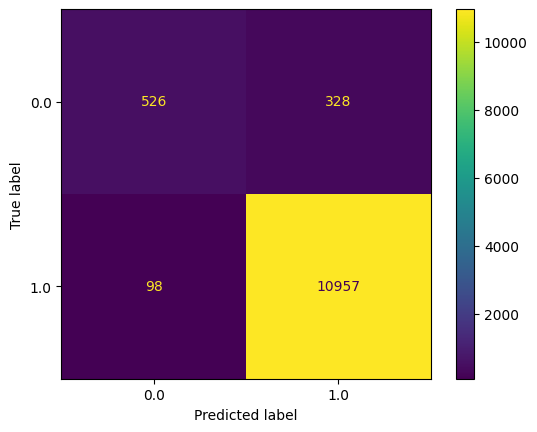

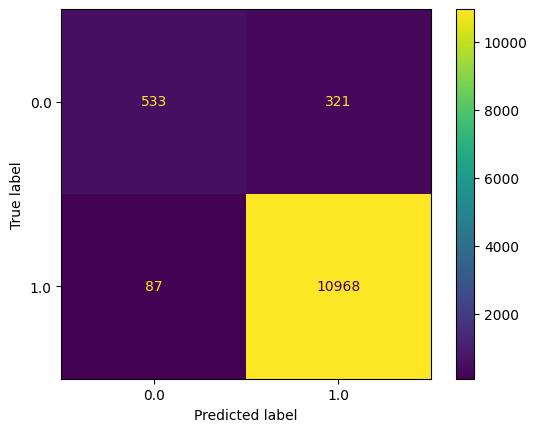

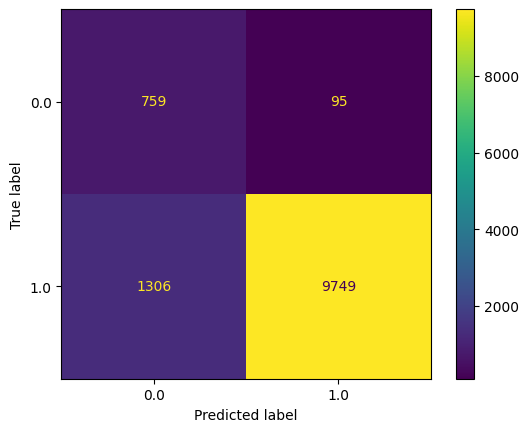

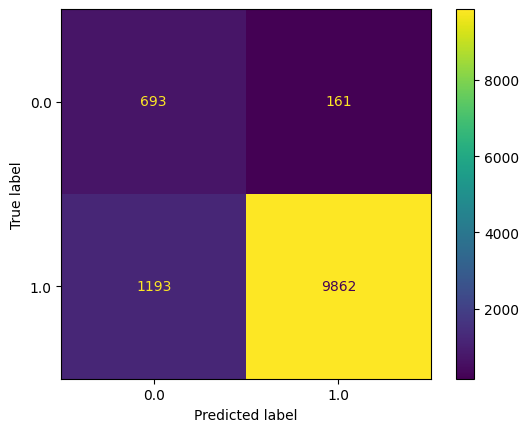

In [6]:
model = select_best_estimator(X, y, preprocessor)

In [7]:
# "Turkey"   : LCZ, NTL, WSF
# "Turkey_2" : LCZ, NTL, WSF, GHSL-H
model_path = os.path.join("data", "ml", "models", "Turkey_residential.pkl")
with open(model_path,"wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
model_path = os.path.join("data", "ml", "models", "Turkey_residential.pkl")
with open(model_path,"rb") as f:
   model = pickle.load(f)

In [8]:
data_path = os.path.join("data", "ml", "datasets", "Turkey.pkl")
with open(data_path,"rb") as f:
   data = pickle.load(f)

In [9]:
prediction = predict(model, 'residential', train, pred, data)

In [10]:
# If the dataset is country-wise
predictions_list = breakdown_cities(prediction)

Ordu
Adana
Trabzon
Manisa


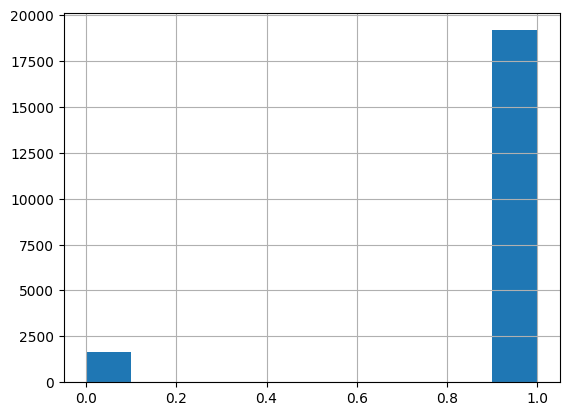

<Figure size 640x480 with 0 Axes>

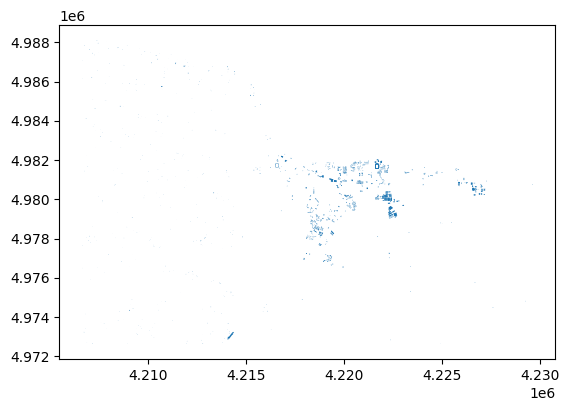

<Figure size 640x480 with 0 Axes>

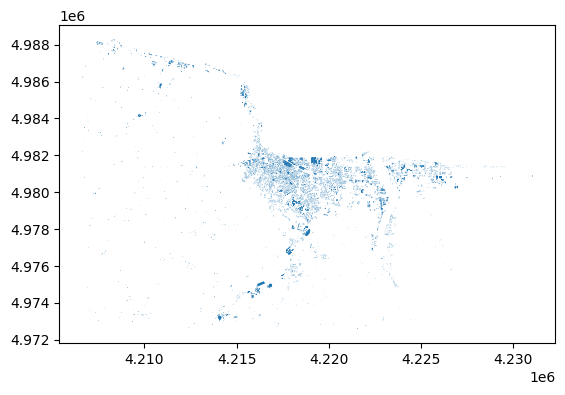

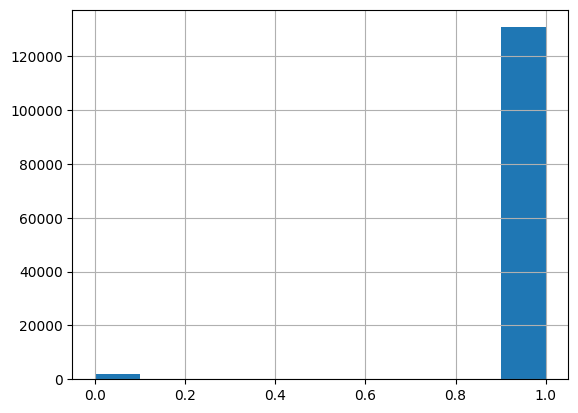

<Figure size 640x480 with 0 Axes>

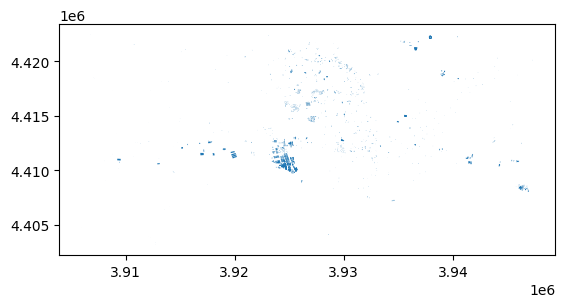

<Figure size 640x480 with 0 Axes>

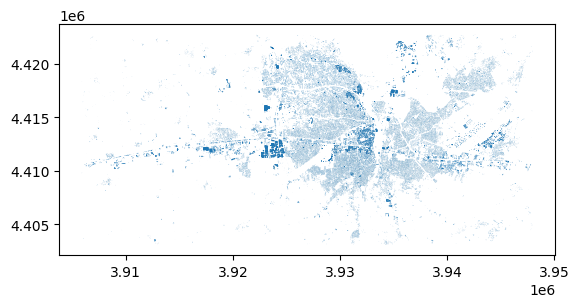

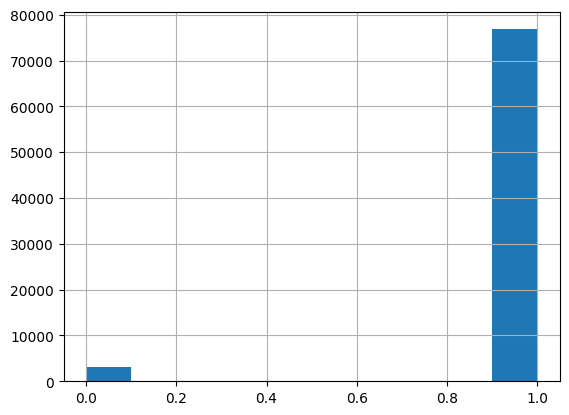

<Figure size 640x480 with 0 Axes>

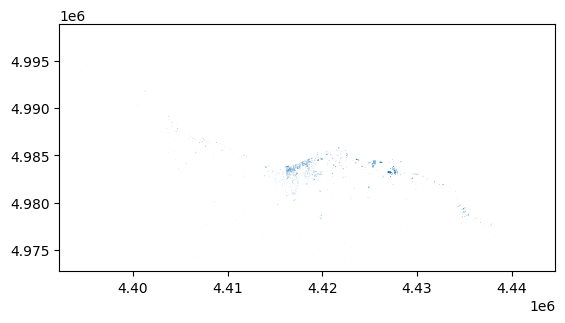

<Figure size 640x480 with 0 Axes>

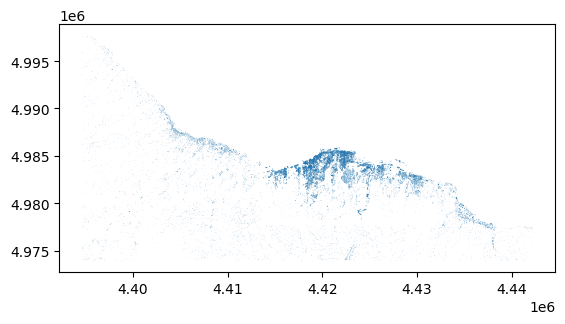

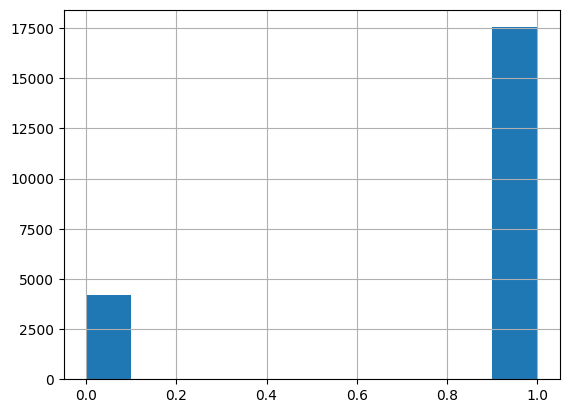

<Figure size 640x480 with 0 Axes>

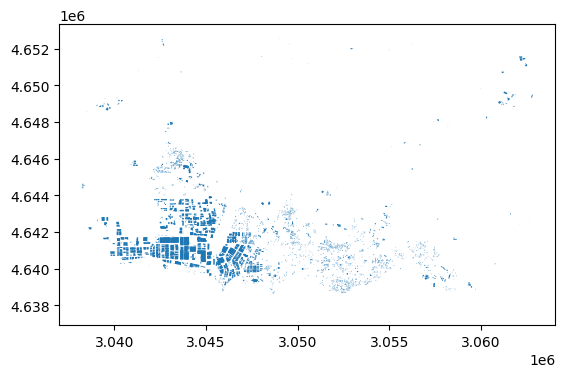

<Figure size 640x480 with 0 Axes>

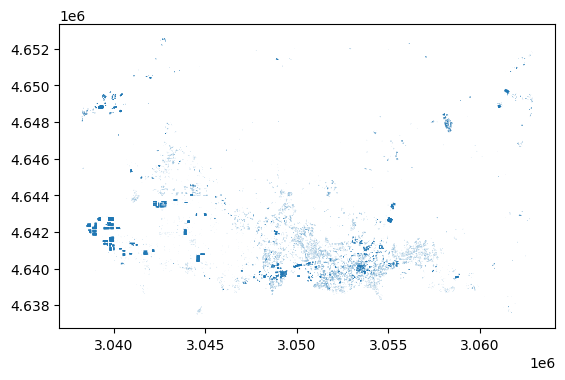

In [11]:
for prediction in predictions_list:
    city = prediction.city.unique()[0]
    print(city)
    result = prediction[ prediction.city == city ]
    plt.figure()
    result.residential_pred.hist()
    result_path = os.path.join("data", "ml", "prediction", 'type', city+".pkl")
    plt.figure()
    result[result['residential_pred']==0].plot()
    plt.figure()
    result = result.drop(result[result['residential_pred'] != 1.0 ].index, axis=0)
    result.plot()
    with open(result_path,"wb") as f:
        pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)

### Cairo

### Johannesburg